In [182]:
# Variáveis Iniciais do Sistema
initial_date = "20-02-2020"
final_date = "22-02-2020"
total_registers = 900
total_users = 1200

# Regioes e Locais cadastrados no sistemas de SmartParking
parkings_data = [
    {
        "parking": "IPB",
        "regions": [
            {
                "name": "ipb-cantina",
                "open_time": "08:00",
                "close_time": "20:00",
                "max_slots": 300,
                "ocuppation_avg": 0.5,
                "variation": 0.8,
                "rush_range": [
                    {
                        "start": "12:00",
                        "finish": "13:00",
                        "increase": 2.5
                    },
                    {
                        "start": "18:00",
                        "finish": "19:00",
                        "increase": 1.8
                    }
                ]
            }
        ]
    }
]

In [183]:
# Importações de Bibliotecas Necessárias
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta  

from random import seed
from random import randint

from matplotlib import pyplot as plt
import matplotlib.dates as md

In [184]:
cols = ["parking","region","timeFrom","timeTo"]

date = datetime.strptime(initial_date, '%d-%m-%Y')
end_date = datetime.strptime(final_date, '%d-%m-%Y')

for park in parkings_data:
    for region in park['regions']:
        region['open_time'] = datetime.strptime(region['open_time'], '%H:%M').time()
        region['close_time'] = datetime.strptime(region['close_time'], '%H:%M').time()
        for rush in region['rush_range']:
            rush['start'] = datetime.strptime(rush['start'], '%H:%M').time()
            rush['finish'] = datetime.strptime(rush['finish'], '%H:%M').time()

print("Start Generating On:", date.strftime('%d-%m-%Y'))
print("Finish Generating On:", end_date.strftime('%d-%m-%Y'))
print("Total Days: ")

Start Generating On: 20-02-2020
Finish Generating On: 22-02-2020
Total Days: 


In [185]:
df = pd.DataFrame(columns=cols)

print("Generating Data...\n")

# Verifica se o horario atual é um horário de maior fluxo para aquela região    
def is_rush_time(region):
    is_rush = False
    rush_increase = 1
    for rush in region['rush_range']:
        if (date.time() >= rush['start'] and date.time() <= rush['finish']):
            is_rush = True
            rush_increase = rush['increase']
    return is_rush, rush_increase

# Define quantos parkings serao criados em cada execucao dependendo se a regiao esta ou nao em horario de maior fluxo
def add_parkings_by_rush(region):
    is_rush, rush_increase = is_rush_time(region)
    
    add_parkings = randint(1,12)
    if (is_rush):
        # Multiplicacao do anterior OU randint(1,3*increase) *****************
        add_parkings = add_parkings * rush_increase
        #add_parkings = randint(1,int(3*rush_increase))
        
    return add_parkings
    

# Percorre cada Parking cadastrado
for park in parkings_data:
    var_parking = park['parking']
    print("Generating Data for Parking: ",var_parking)
    # Percorre cada Região do parking
    for region in park['regions']:
        var_region = region['name']
        print("\tGenerating Data for Region: ",var_region)
        
        # Obtem os horarios de abertura e fechamento da Região do Parking
        open_time = region['open_time']
        close_time = region['close_time']
        
        # Zera a data de inicio e fim para iniciar a criacao de dados
        date = datetime.strptime(initial_date, '%d-%m-%Y')
        date = date.replace(hour=open_time.hour, minute=open_time.minute)
        end_date = datetime.strptime(final_date, '%d-%m-%Y')
        
        # Zera a lista do estacionamento
        parkings = []        
        
        while(date < end_date):
            
            # Chance do estaciomamento durar: [ Ate 60min : 70%  | Acima de 60min: 30% ]
            parking_time = randint(10,60)
            if (randint(1,10) > 7):
                parking_time = randint(61,300)
            
            add_parkings = add_parkings_by_rush(region)
            
            # Insere estacionamentos na base de dados
            while (add_parkings > 0):
                # Cria uma ROW
                row = {'parking': var_parking, 'region': var_region}
                row.update({'timeFrom': date.strftime('%d-%m-%Y %H:%M')})
                
                # Adiciona o Role ***********************************************
                validate_date = date + timedelta(minutes=parking_time)

                if (validate_date.hour >= close_time.hour and validate_date.minute >= close_time.minute):
                    row.update({'timeTo': (date.replace(hour=close_time.hour, minute=close_time.minute).strftime('%d-%m-%Y %H:%M')) })
                elif (validate_date.hour < open_time.hour):
                    row.update({'timeTo': (date.replace(hour=close_time.hour, minute=close_time.minute).strftime('%d-%m-%Y %H:%M')) })
                else:
                    row.update({'timeTo': validate_date.strftime('%d-%m-%Y %H:%M')})

                # Finaliza o Role ***********************************************                
                df = df.append(row, ignore_index=True)
                
                # Adiciona Horas no sistema
                addMin = randint(1, 15)
                date = date + timedelta(minutes=addMin)
                
                # Verifica se a nova hora e data é valida
                """
                if (date.hour > close_time.hour) or (date.hour == close_time.hour and date.minute >= close_time.minute):
                    date = date + timedelta(days=1)
                    date = date.replace(hour=open_time.hour, minute=open_time.minute)
                elif( (date.hour == close_time.hour-1) and (60 - date.minute <= 15)):
                    date = date + timedelta(days=1)
                    date = date.replace(hour=open_time.hour, minute=open_time.minute)
                elif (date.hour < open_time.hour):
                    date = date.replace(hour=open_time.hour, minute=open_time.minute)
                """
                if not(date.time() >= open_time and date.time() <= close_time):
                    date = date + timedelta(days=1)
                    date = date.replace(hour=open_time.hour, minute=open_time.minute)
                
                add_parkings -= 1
                
    print("\n")
    
print("\nDone!")

Generating Data...

Generating Data for Parking:  IPB
	Generating Data for Region:  ipb-cantina



Done!


In [186]:
df

,parking,region,timeFrom,timeTo
0,IPB,ipb-cantina,20-02-2020 08:00,20-02-2020 08:52
1,IPB,ipb-cantina,20-02-2020 08:01,20-02-2020 08:42
2,IPB,ipb-cantina,20-02-2020 08:12,20-02-2020 08:53
3,IPB,ipb-cantina,20-02-2020 08:19,20-02-2020 09:00
4,IPB,ipb-cantina,20-02-2020 08:20,20-02-2020 09:01
...,...,...,...,...
176,IPB,ipb-cantina,21-02-2020 19:49,21-02-2020 20:00
177,IPB,ipb-cantina,21-02-2020 19:54,21-02-2020 20:00
178,IPB,ipb-cantina,22-02-2020 08:00,22-02-2020 08:54
179,IPB,ipb-cantina,22-02-2020 08:10,22-02-2020 09:04


In [187]:
print("Writing output file...")
df.to_csv('generated_dataset_v2.csv', index=False)
print("Done!")

Writing output file...
Done!


In [188]:
print("Reading CSV...")
df = pd.read_csv('generated_dataset_v2.csv')
#df = df.drop('timeTo',axis=1)

print("Setting the Pattern in DateTime Columns...")
df['timeFrom'] = pd.to_datetime(df['timeFrom'], errors='ignore')
df['timeFrom'] = pd.to_datetime(df["timeFrom"].dt.strftime('%d-%m-%Y %H:%M'))

print("Done!")

df

Reading CSV...
Setting the Pattern in DateTime Columns...
Done!


,parking,region,timeFrom,timeTo
0,IPB,ipb-cantina,2020-02-20 08:00:00,20-02-2020 08:52
1,IPB,ipb-cantina,2020-02-20 08:01:00,20-02-2020 08:42
2,IPB,ipb-cantina,2020-02-20 08:12:00,20-02-2020 08:53
3,IPB,ipb-cantina,2020-02-20 08:19:00,20-02-2020 09:00
4,IPB,ipb-cantina,2020-02-20 08:20:00,20-02-2020 09:01
...,...,...,...,...
176,IPB,ipb-cantina,2020-02-21 19:49:00,21-02-2020 20:00
177,IPB,ipb-cantina,2020-02-21 19:54:00,21-02-2020 20:00
178,IPB,ipb-cantina,2020-02-22 08:00:00,22-02-2020 08:54
179,IPB,ipb-cantina,2020-02-22 08:10:00,22-02-2020 09:04


In [170]:
df1 = df.copy()
df1 = df1[['timeFrom']]

print("Setting the Pattern in DateTime Columns...")
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Grouping by Day...")
df1 = df1.groupby(df1['timeFrom'].dt.date).size().reset_index(name='TotalParkings')

print("Done!")
df1

Setting the Pattern in DateTime Columns...
Grouping by Day...
Done!


,timeFrom,TotalParkings
0,2020-02-20,323
1,2020-02-21,330
2,2020-02-22,3


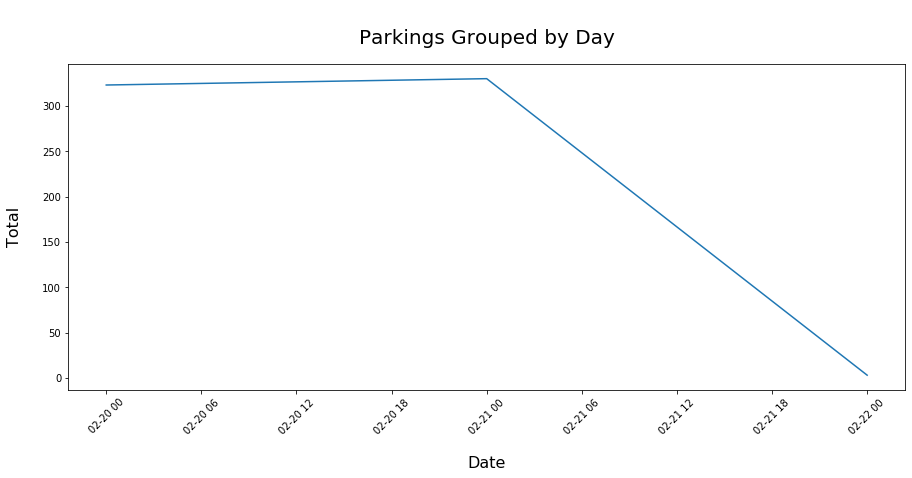

In [172]:
df3 = df1.copy()
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(15,6))
plt.title("\nParkings Grouped by Day", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.plot(df3)

In [128]:
df2 = df1.copy()
print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
df2 = df2.groupby(pd.Grouper(freq='M', key='timeFrom')).sum().reset_index()
df2['timeFrom'] = df2['timeFrom'].dt.strftime('%m-%Y')

print("Done!")
df2

Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


,timeFrom,TotalParkings
0,02-2020,1124
1,03-2020,2333


Grouping by Month


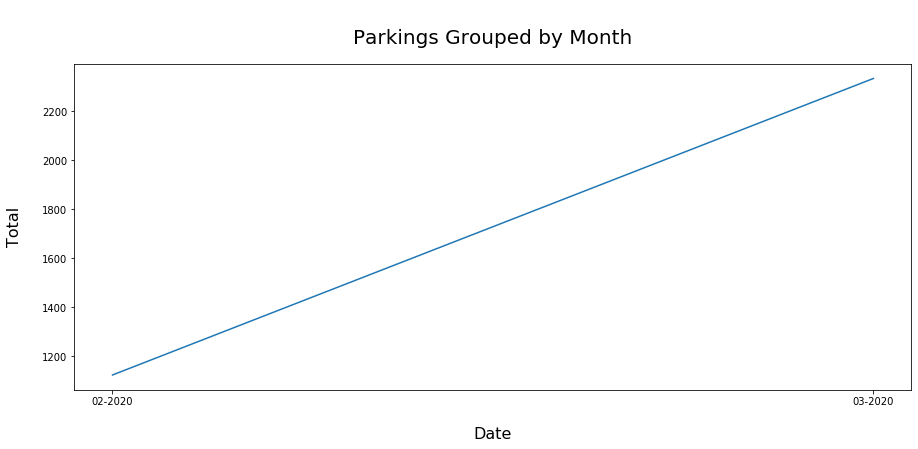

In [129]:
df3 = df2.copy()

print("Grouping by Month")
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(15,6))
plt.title("\nTotal: "+str(len(df['timeTo'])), fontsize=30, pad=20)
plt.title("\nParkings Grouped by Month", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.plot(df3)

Setting the Pattern in DateTime Columns...
Setting Query for Specific Day and Month...
Generating Graph...


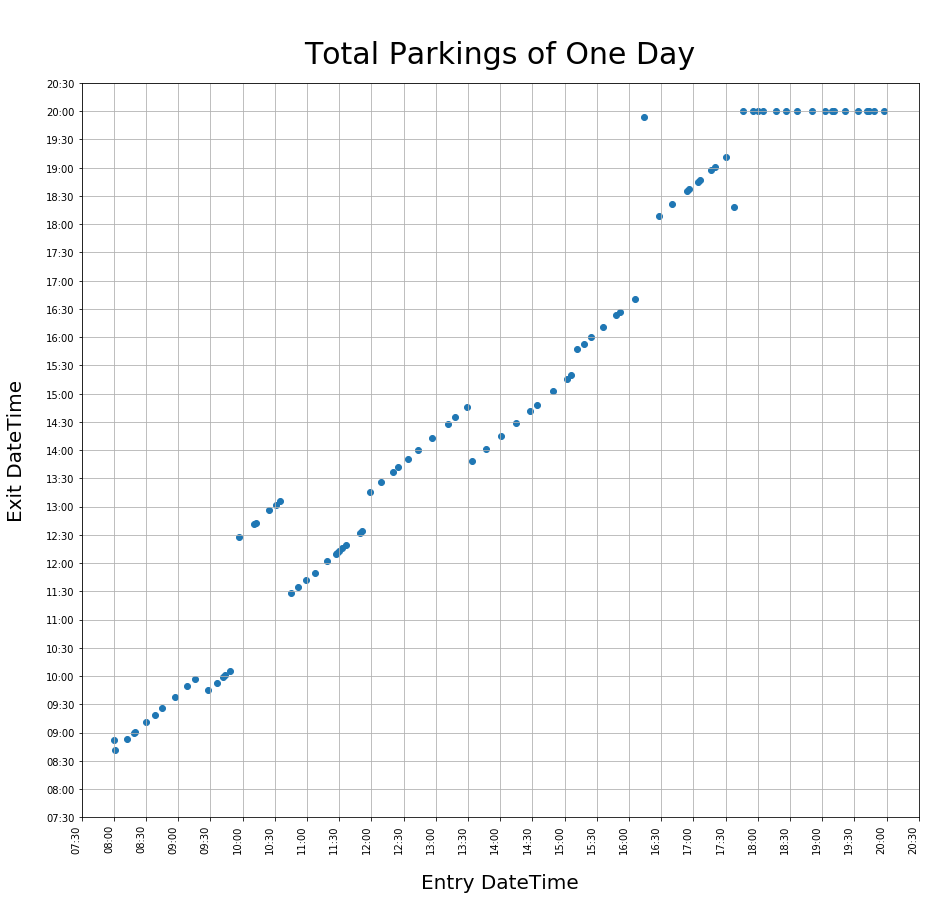

In [189]:
df4 = df.copy()
df4 = df4[['timeFrom','timeTo']]

print("Setting the Pattern in DateTime Columns...")
df4['timeFrom'] = pd.to_datetime(df4['timeFrom'], errors='ignore')
df4['timeFrom'] = pd.to_datetime(df4["timeFrom"].dt.strftime('%d/%m/%Y %H:%M'))

df4['timeTo'] = pd.to_datetime(df4['timeTo'], errors='ignore')
df4['timeTo'] = pd.to_datetime(df4["timeTo"].dt.strftime('%d/%m/%Y %H:%M'))

# Query For Specific Day
print("Setting Query for Specific Day and Month...")
df4 = df4[(df4['timeFrom'].dt.month == 2) & (df4['timeFrom'].dt.day == 20)]

print("Generating Graph...")
fig, ax = plt.subplots(figsize=(15,15))

max_y = 0
min_x = 0

while ((df4['timeTo'].max().minute + max_y) % 30 != 0):
    max_y += 1
    
while ((df4['timeFrom'].min().minute + min_x) % 30 != 0):
    min_x -= 1

min_x = min_x + 30
max_y = max_y + 30
    
plt.scatter(x=df4['timeFrom'], y=df4['timeTo'])

ax.set_xlim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.set_ylim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.xaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.yaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.yaxis.set_major_formatter(md.DateFormatter('%H:%M'))

fig.autofmt_xdate()

plt.title("\nTotal Parkings of One Day", fontsize=30, pad=20)
plt.xlabel("Entry DateTime", fontsize=20, labelpad=20)
plt.ylabel("Exit DateTime", fontsize=20, labelpad=20)

plt.xticks(rotation=90)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))

plt.grid()
plt.show()